<a href="https://colab.research.google.com/github/suhrobm/Methods-and-Models-for-Multivariate-Data-Analysis/blob/main/Lab3_Suhrob_Munavarov_J4134c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TASK 3. SAMPLING OF MULTIVARIATE RANDOM VARIABLES

---

### Content 🎯

1. Substantiation of Chosen Sampling
2. Sampling of Chosen Target Variables Using Univariate Parametric 
3. Distributions with 2 Different Sampling Methods
4. Estimation of Relations Between Predictors and Chosen Target Variables
5. Bayesian Network. Part I
6. Bayesian Network. Part II
7. Quality Analysis



# **About Dataset**

In this task, the previous chosen dataset is being used.

#  **About this file:** 

**url:** the url which fetches the data

**id:** the id of transaction

**Lng:** and Lat coordinates, using the BD09 protocol

**Cid:** community id

**tradeTime:** the time of transaction

**DOM:** active days on market. Know more in https://en.wikipedia.org/wiki/Days_on_market

**followers:** the number of people follow the transaction

**totalPrice:** the total price

**price:** the average price by square

**square:** the square of house

**livingRoom:** the number of living room

**drawingRoom:** the number of drawing room

**kitchen:** the number of kitchen

**bathroom:** the number of bathroom

**floor:** the height of the house. I will turn the Chinese characters to English in the next version

**buildingType:** including tower (1), bungalow (2), combination of plate and tower (3), plate (4)

**constructionTime:** the time of construction

**renovationCondition:** including other (1), rough (2), Simplicity (3), hardcover (4)

**buildingStructure:** including unknow (1), mixed (2), brick and wood (3), brick and concrete (4), steel (5) and steel-concrete composite (6)

**ladderRatio:** the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average elevator have (1) or not have elevator (0)

**fiveYearsProperty:** if the owner have the property for less than 5 years

### 1. Substantiation of Chosen Sampling

In [1]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats
import warnings

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

from google.colab import drive
drive.mount('/content/drive')

# prevents numpy scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=False, formatter={'float_kind':'{:0.2f}'.format})
# ignoring warnings
warnings.filterwarnings(action='ignore')



Mounted at /content/drive


In [3]:
# Reading whole dataset from file and loading the data and save it in a DataFrame 
df = pd.read_csv('/content/drive/MyDrive/MMMDA/Housing price in Beijing.csv', encoding = 'ISO-8859-1')
print(df.shape)
df.head(3)

(318851, 26)


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0


In [4]:
# info() helps us to see how many values are existing in each column and their data type.
# Here, we can see many columns have missing values which we need to fill with some sensible values. 
# Handling missing data is important as many machine learning algorithms do not support data with missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

In [5]:
df = df[['Lng', 'Lat', 'price', 'square', 'totalPrice', 'renovationCondition', 'buildingType', 'elevator']]

q75, q25 = np.percentile(df['Lng'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['Lng'] < min_dist) | (df['Lng'] > max_dist), ('Lng')] = np.nan

q75, q25 = np.percentile(df['Lat'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['Lat'] < min_dist) | (df['Lat'] > max_dist), ('Lat')] = np.nan

q75, q25 = np.percentile(df['price'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['price'] < min_dist) | (df['price'] > max_dist), ('price')] = np.nan

q75, q25 = np.percentile(df['square'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['square'] < min_dist) | (df['square'] > max_dist), ('square')] = np.nan

q75, q25 = np.percentile(df['totalPrice'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['totalPrice'] < min_dist) | (df['totalPrice'] > max_dist), ('totalPrice')] = np.nan

q75, q25 = np.percentile(df['renovationCondition'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['renovationCondition'] < min_dist) | (df['renovationCondition'] > max_dist), ('renovationCondition')] = np.nan

q75, q25 = np.percentile(df['buildingType'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['buildingType'] < min_dist) | (df['buildingType'] > max_dist), ('buildingType')] = np.nan

q75, q25 = np.percentile(df['elevator'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['elevator'] < min_dist) | (df['elevator'] > max_dist), ('elevator')] = np.nan

df.dropna(inplace=True)
df.head(3)

,Lng,Lat,price,square,totalPrice,renovationCondition,buildingType,elevator
0,116.475489,40.019520,31680.0,131.00,415.0,3.0,1.0,1.0
1,116.453917,39.881534,43436.0,132.38,575.0,4.0,1.0,1.0
3,116.438010,40.076114,22202.0,134.00,297.5,1.0,1.0,1.0


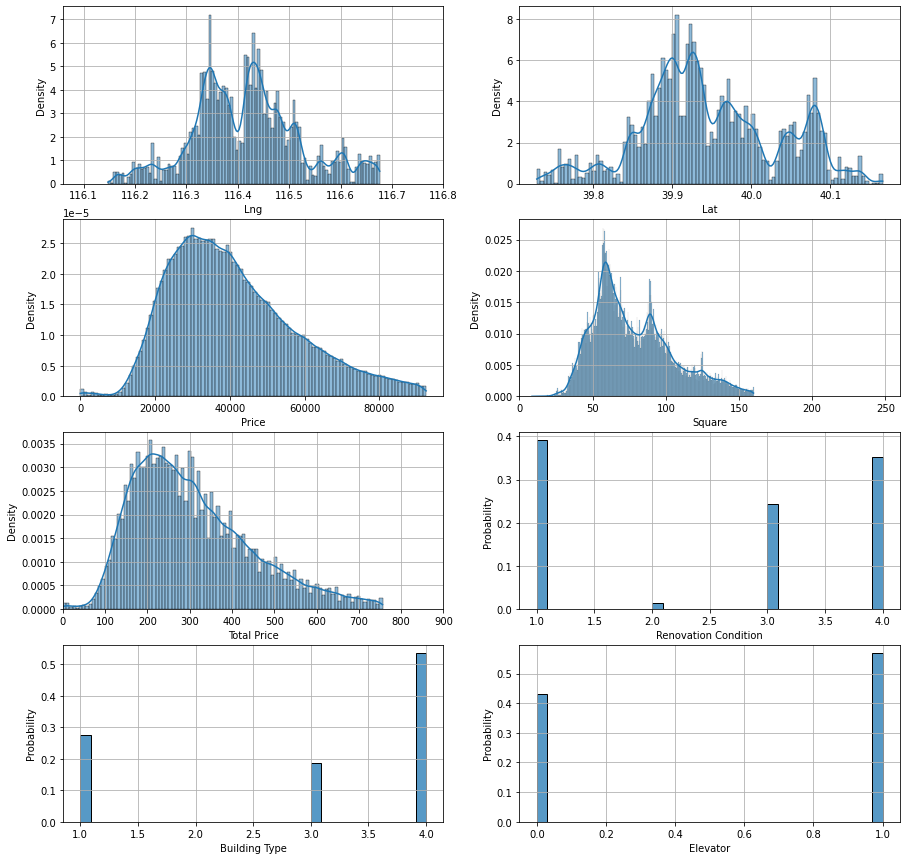

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

plt.subplot(421)
sns.histplot(df.Lng, bins=100, kde=True, stat='density')
plt.xlim(116.06, 116.8)
plt.grid(True)
plt.xlabel('Lng')
plt.ylabel('Density')

plt.subplot(422)
sns.histplot(df.Lat, bins=100, kde=True, stat='density')
plt.grid(True)
plt.xlabel('Lat')
plt.ylabel('Density')

plt.subplot(423)
sns.histplot(df.price, bins=100, kde=True, stat='density')
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Density')

plt.subplot(424)
sns.histplot(df.square, bins=500, kde=True, stat='density')
plt.xlim(0, 260)
plt.grid(True)
plt.xlabel('Square')
plt.ylabel('Density')

plt.subplot(425)
sns.histplot(df.totalPrice, bins=100, kde=True, stat='density')
plt.xlim(0, 900)
plt.grid(True)
plt.xlabel('Total Price')
plt.ylabel('Density')

plt.subplot(426)
sns.histplot(df.renovationCondition, kde=False, stat='probability')
plt.grid(True)
plt.xlabel('Renovation Condition')
plt.ylabel('Probability')

plt.subplot(427)
sns.histplot(df.buildingType, kde=False, stat='probability')
plt.grid(True)
plt.xlabel('Building Type')
plt.ylabel('Probability')

plt.subplot(428)
sns.histplot(df.elevator, kde=False, stat='probability')
plt.grid(True)
plt.xlabel('Elevator')
plt.ylabel('Probability')


plt.show()



### 2. Sampling of Chosen Target Variables Using Univariate Parametric Distributions with 2 Different Sampling Methods

In [7]:
# creating needed functions

def inverse_transform_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample= sample.ppf(data)
    return sample

def custom_sampling(array, distribution):
    args = distribution.fit(array)
    sample = distribution.rvs(*args, size=len(array))
    return sample

def return_cdf(array):
    bins, x = np.histogram(array, bins=100)
    probas = bins / sum(bins)
    y = np.cumsum(probas)
    return x[:100], y[:100]



Distribution beta_gen arguments: (43.19045346880784, 279.0710374003818, 115.68130025591468, 5.496224727095205)
Distribution beta_gen arguments: (4.448322629167592, 4.528540323980547, 39.674606689090645, 0.5492626935767415)
Distribution beta_gen arguments: (6.550330641926786, 44.47057975814867, 3.855085311538418, 576.0038212543047)
Distribution beta_gen arguments: (5.679855989925812, 1465023.412441886, -25.77278074027931, 85693282.35199541)


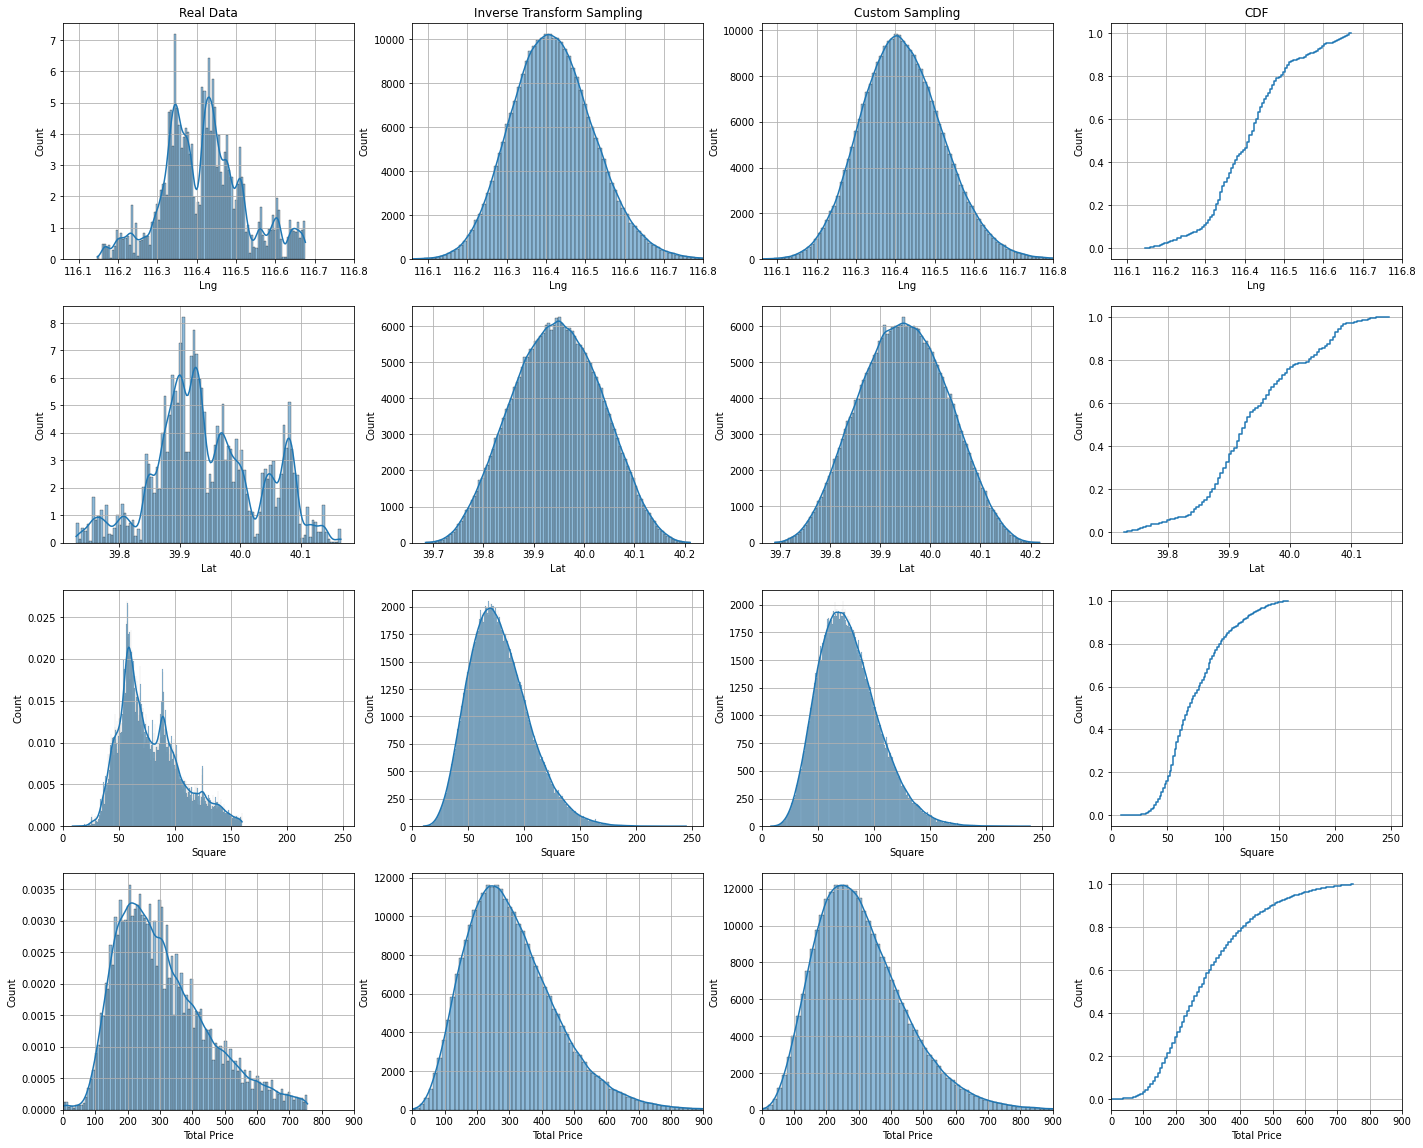

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(24, 20))

plt.subplot(4,4,1)
sns.histplot(df.Lng, bins=100, kde=True, stat='density')
plt.xlim(116.06, 116.8)
plt.grid(True)
plt.xlabel('Lng')
plt.ylabel('Count')
plt.title('Real Data')

plt.subplot(4,4,2)
sns.histplot(inverse_transform_sampling(df.Lng, distribution=scipy.stats.beta), bins=100, kde=True)
plt.xlim(116.06, 116.8)
plt.grid(True)
plt.xlabel('Lng')
plt.ylabel('Count')
plt.title('Inverse Transform Sampling')

plt.subplot(4,4,3)
sns.histplot(custom_sampling(df.Lng, distribution=scipy.stats.beta), bins=100, kde=True)
plt.xlim(116.06, 116.8)
plt.grid(True)
plt.xlabel('Lng')
plt.ylabel('Count')
plt.title('Custom Sampling')

plt.subplot(4,4,4)
sns.lineplot(return_cdf(df.Lng)[0], return_cdf(df.Lng)[1], drawstyle='steps-pre')
plt.xlim(116.06, 116.8)
plt.grid(True)
plt.xlabel('Lng')
plt.ylabel('Count')
plt.title('CDF')

#------------------------------------------------------------
plt.subplot(4,4,5)
sns.histplot(df.Lat, bins=100, kde=True, stat='density')
plt.grid(True)
plt.xlabel('Lat')
plt.ylabel('Count')

plt.subplot(4,4,6)
sns.histplot(inverse_transform_sampling(df.Lat, distribution=scipy.stats.beta), bins=100, kde=True)
plt.grid(True)
plt.xlabel('Lat')
plt.ylabel('Count')

plt.subplot(4,4,7)
sns.histplot(custom_sampling(df.Lat, distribution=scipy.stats.beta), bins=100, kde=True)
plt.grid(True)
plt.xlabel('Lat')
plt.ylabel('Count')

plt.subplot(4,4,8)
sns.lineplot(return_cdf(df.Lat)[0], return_cdf(df.Lat)[1], drawstyle='steps-pre')
plt.grid(True)
plt.xlabel('Lat')
plt.ylabel('Count')

#------------------------------------------------------------
plt.subplot(4,4,9)
sns.histplot(df.square, bins=500, kde=True, stat='density')
plt.xlim(0, 260)
plt.grid(True)
plt.xlabel('Square')
plt.ylabel('Count')

plt.subplot(4,4,10)
sns.histplot(inverse_transform_sampling(df.square, distribution=scipy.stats.beta), bins=500, kde=True)
plt.xlim(0, 260)
plt.grid(True)
plt.xlabel('Square')
plt.ylabel('Count')

plt.subplot(4,4,11)
sns.histplot(custom_sampling(df.square, distribution=scipy.stats.beta), bins=500, kde=True)
plt.xlim(0, 260)
plt.grid(True)
plt.xlabel('Square')
plt.ylabel('Count')

plt.subplot(4,4,12)
sns.lineplot(return_cdf(df.square)[0], return_cdf(df.square)[1], drawstyle='steps-pre')
plt.xlim(0, 260)
plt.grid(True)
plt.xlabel('Square')
plt.ylabel('Count')

#------------------------------------------------------------
plt.subplot(4,4,13)
sns.histplot(df.totalPrice, bins=100, kde=True, stat='density')
plt.xlim(0, 900)
plt.grid(True)
plt.xlabel('Total Price')
plt.ylabel('Count')

plt.subplot(4,4,14)
sns.histplot(inverse_transform_sampling(df.totalPrice, distribution=scipy.stats.beta), bins=100, kde=True)
plt.xlim(0, 900)
plt.grid(True)
plt.xlabel('Total Price')
plt.ylabel('Count')

plt.subplot(4,4,15)
sns.histplot(custom_sampling(df.totalPrice, distribution=scipy.stats.beta), bins=100, kde=True)
plt.xlim(0, 900)
plt.grid(True)
plt.xlabel('Total Price')
plt.ylabel('Count')

plt.subplot(4,4,16)
sns.lineplot(return_cdf(df.totalPrice)[0], return_cdf(df.totalPrice)[1], drawstyle='steps-pre')
plt.xlim(0, 900)
plt.grid(True)
plt.xlabel('Total Price')
plt.ylabel('Count')

plt.show()

In [9]:
df_it_sampling = pd.DataFrame(data={  'Lng': inverse_transform_sampling(df.Lng, distribution=scipy.stats.beta),
                                      'Lat': inverse_transform_sampling(df.Lat, distribution=scipy.stats.beta),
                                      'price': inverse_transform_sampling(df.price, distribution=scipy.stats.beta),
                                      'square': inverse_transform_sampling(df.square, distribution=scipy.stats.beta),
                                      'totalPrice': inverse_transform_sampling(df.totalPrice, distribution=scipy.stats.beta),
                                      'renovationCondition': df.renovationCondition,
                                      'buildingType': df.buildingType,
                                      'elevator': df.elevator
                                    })

df_it_sampling.head(3)

Distribution beta_gen arguments: (43.19045346880784, 279.0710374003818, 115.68130025591468, 5.496224727095205)
Distribution beta_gen arguments: (4.448322629167592, 4.528540323980547, 39.674606689090645, 0.5492626935767415)
Distribution beta_gen arguments: (7.565193068539429, 13795.087653105798, -5593.695217472698, 85118834.1505669)
Distribution beta_gen arguments: (6.550330641926786, 44.47057975814867, 3.855085311538418, 576.0038212543047)
Distribution beta_gen arguments: (5.679855989925812, 1465023.412441886, -25.77278074027931, 85693282.35199541)


,Lng,Lat,price,square,totalPrice,renovationCondition,buildingType,elevator
0,116.453686,39.990899,50182.345657,129.757526,181.244632,3.0,1.0,1.0
1,116.505695,39.948298,60670.262478,112.440827,294.479407,4.0,1.0,1.0
3,116.468806,40.077187,58902.755908,118.669727,248.892219,1.0,1.0,1.0


In [10]:
df_cus_sampling = pd.DataFrame(data={  'Lng': custom_sampling(df.Lng, distribution=scipy.stats.beta),
                                       'Lat': custom_sampling(df.Lat, distribution=scipy.stats.beta),
                                       'price': custom_sampling(df.price, distribution=scipy.stats.beta),
                                       'square': custom_sampling(df.square, distribution=scipy.stats.beta),
                                       'totalPrice': custom_sampling(df.totalPrice, distribution=scipy.stats.beta),
                                       'renovationCondition': df.renovationCondition,
                                       'buildingType': df.buildingType,
                                       'elevator': df.elevator
                                    })

df_cus_sampling.head(3)

,Lng,Lat,price,square,totalPrice,renovationCondition,buildingType,elevator
0,116.308623,40.042095,45203.327688,84.240095,557.213447,3.0,1.0,1.0
1,116.269752,39.945460,32429.345254,120.245912,110.774453,4.0,1.0,1.0
3,116.550449,39.763281,68359.681343,108.904599,296.792990,1.0,1.0,1.0


Estimation of multivariate mathematical expectation and variance for inverse transform sample

In [11]:
df_it_sampling[['Lng', 'Lat', 'price', 'square', 'totalPrice']].mean()

Lng             116.417743
Lat              39.946984
price         41040.278822
square           77.810130
totalPrice      306.675101
dtype: float64

In [12]:
df_it_sampling[['Lng', 'Lat', 'price', 'square', 'totalPrice']].var()

Lng           1.074157e-02
Lat           7.556794e-03
price         2.865970e+08
square        7.124938e+02
totalPrice    1.933331e+04
dtype: float64

Estimation of multivariate mathematical expectation and variance for custom sample


In [13]:
df_cus_sampling[['Lng', 'Lat', 'price', 'square', 'totalPrice']].mean()

Lng             116.417851
Lat              39.946797
price         41030.226971
square           77.770145
totalPrice      306.358021
dtype: float64

In [14]:
df_cus_sampling[['Lng', 'Lat', 'price', 'square', 'totalPrice']].var()

Lng           1.085638e-02
Lat           7.560812e-03
price         2.874417e+08
square        7.110635e+02
totalPrice    1.938407e+04
dtype: float64

Plotting Q-Q graph

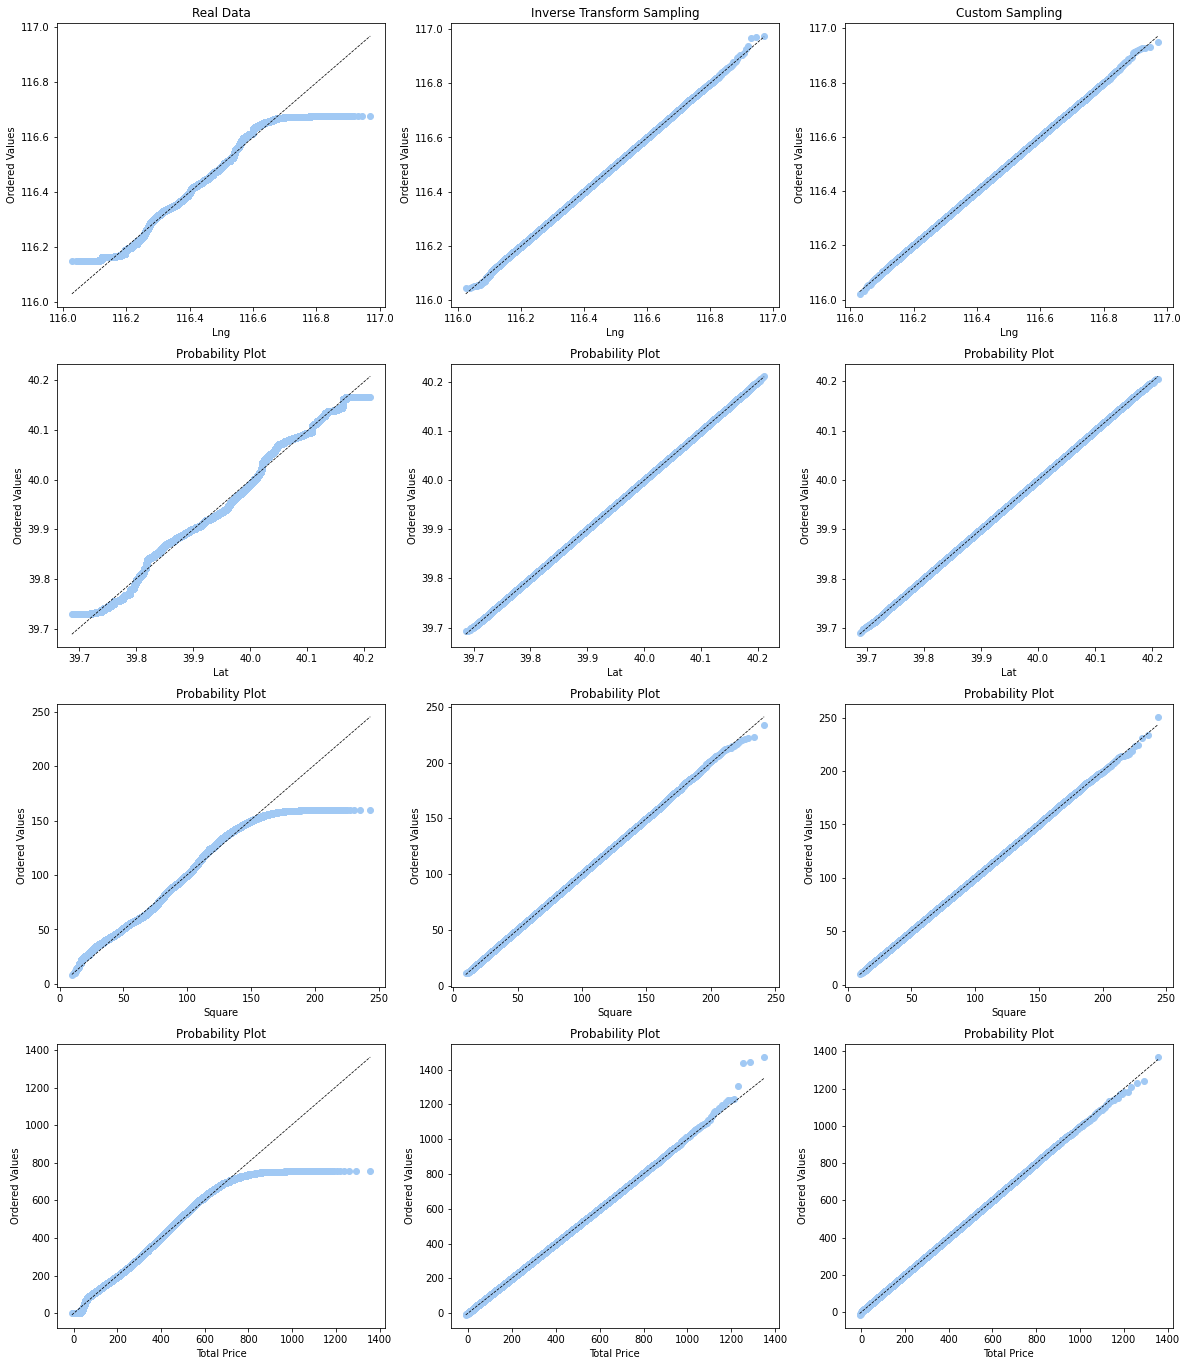

In [15]:
def return_biplot(array, distribution, ax):
    args = distribution.fit(array)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    
    ax.get_lines()[0].set_marker('o')
    
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)


figure, ax = plt.subplots(4, 3, figsize=(20, 24))
sns.set_theme(style='whitegrid', palette='pastel')

return_biplot(df.Lng, distribution=scipy.stats.beta, ax=ax[0, 0])
return_biplot(df_it_sampling.Lng, distribution=scipy.stats.beta, ax=ax[0, 1])
return_biplot(df_cus_sampling.Lng, distribution=scipy.stats.beta, ax=ax[0, 2])

return_biplot(df.Lat, distribution=scipy.stats.beta, ax=ax[1, 0])
return_biplot(df_it_sampling.Lat, distribution=scipy.stats.beta, ax=ax[1, 1])
return_biplot(df_cus_sampling.Lat, distribution=scipy.stats.beta, ax=ax[1, 2])

return_biplot(df.square, distribution=scipy.stats.beta, ax=ax[2, 0])
return_biplot(df_it_sampling.square, distribution=scipy.stats.beta, ax=ax[2, 1])
return_biplot(df_cus_sampling.square, distribution=scipy.stats.beta, ax=ax[2, 2])

return_biplot(df.totalPrice, distribution=scipy.stats.beta, ax=ax[3, 0])
return_biplot(df_it_sampling.totalPrice, distribution=scipy.stats.beta, ax=ax[3, 1])
return_biplot(df_cus_sampling.totalPrice, distribution=scipy.stats.beta, ax=ax[3, 2])


ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('Custom Sampling')

ax[0, 0].set(xlabel='Lng')
ax[0, 1].set(xlabel='Lng')
ax[0, 2].set(xlabel='Lng')
ax[1, 0].set(xlabel='Lat')
ax[1, 1].set(xlabel='Lat')
ax[1, 2].set(xlabel='Lat')
ax[2, 0].set(xlabel='Square')
ax[2, 1].set(xlabel='Square')
ax[2, 2].set(xlabel='Square')
ax[3, 0].set(xlabel='Total Price')
ax[3, 1].set(xlabel='Total Price')
ax[3, 2].set(xlabel='Total Price')


plt.show()



### 3. Estimation of Relations Between Predictors and Chosen Target Variables

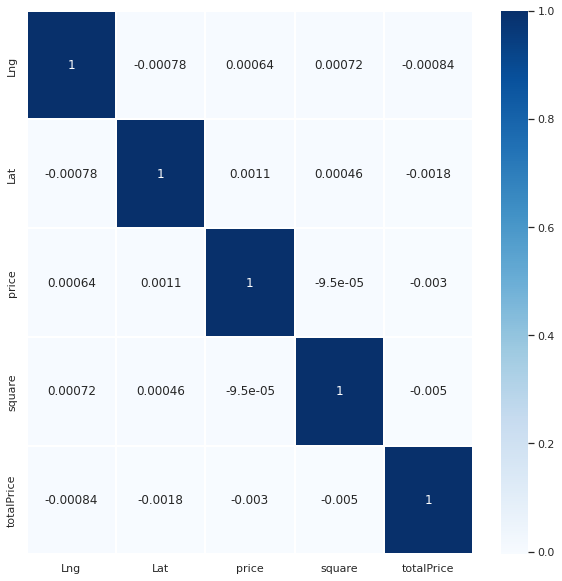

In [16]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df_it_sampling[['Lng', 'Lat', 'price', 'square', 'totalPrice']].corr(), cmap='Blues', annot=True, linewidths=0.25)

plt.show()



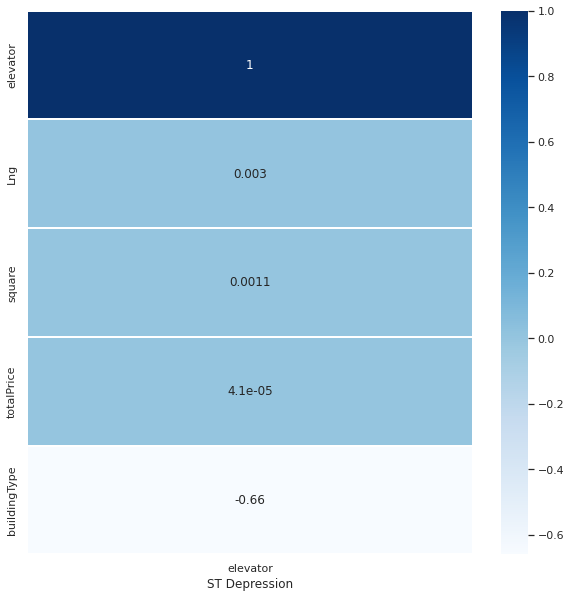

In [17]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(
    df_cus_sampling[['Lng', 'buildingType', 'square', 'totalPrice', 'elevator']].corr()[['elevator']].sort_values(by='elevator', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25
)

ax.set(xlabel='ST Depression')
plt.show()



### 4. Bayesian Network. Part I

Building a Bayesian network based on multivariet data analysis

In [18]:
# data preparation
column_names = ['square', 'totalPrice', 'renovationCondition', 'buildingType', 'elevator']
df = df_it_sampling[column_names]

discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df.values)
df_discretized = pd.DataFrame(df_discretized, columns=column_names)
df_discretized.head(3)

,square,totalPrice,renovationCondition,buildingType,elevator
0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0


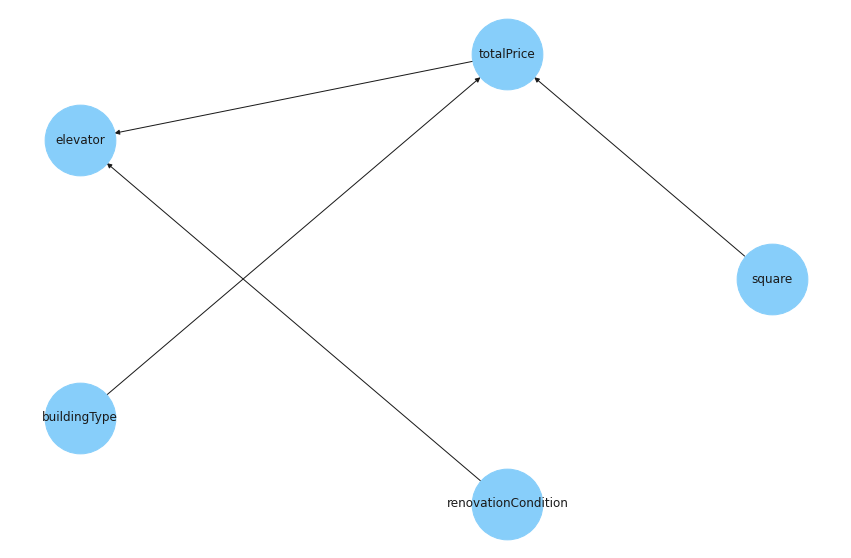

In [19]:
edges_list = [
    ('square', 'totalPrice'),
    ('buildingType', 'totalPrice'),
    ('totalPrice', 'elevator'),
    ('renovationCondition', 'elevator')
]

model = BayesianModel(edges_list)

figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()


### 5. Bayesian Network. Part II

Hill Climb Search

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

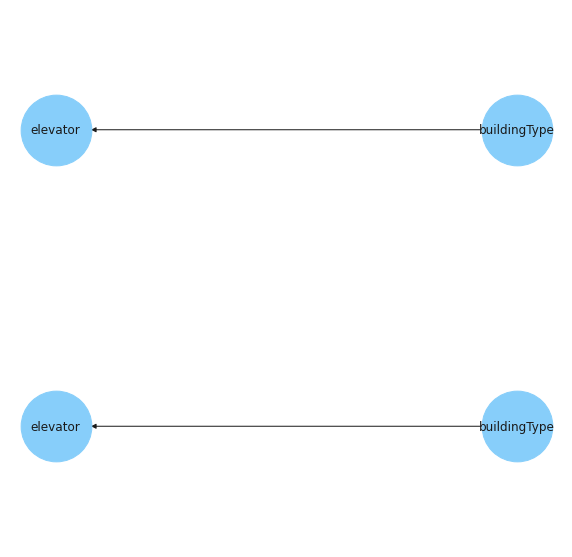

In [20]:
hc_search = HillClimbSearch(data=df_discretized)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_discretized))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_discretized))

figure, ax = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2,1,1)
graph = nx.DiGraph()
graph.add_edges_from(hc_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)


plt.subplot(2,1,2)
graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()





Tree search

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

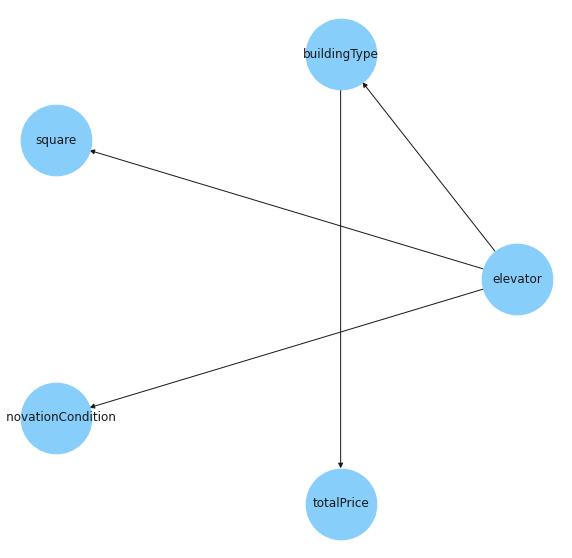

In [21]:
e_search = TreeSearch(data=df_discretized)
e_model = e_search.estimate()

figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()



### 6. Quality Analysis

In [26]:
def return_sample(model, data, size):
    model_s = BayesianModel(model.edges())
    model_s.fit(data)
    
    sampling = BayesianModelSampling(model_s)
    sample = sampling.forward_sample(size=size)
    return sample

sample_hc = return_sample(hc_k2, df_discretized, df_discretized.shape[0])
sample_e = return_sample(e_model, df_discretized, df_discretized.shape[0])
sample_our = return_sample(model, df_discretized, df_discretized.shape[0])


print(f'\n Elevator Estimation:\n')
print(classification_report(df_discretized.elevator, sample_hc.elevator))
print(classification_report(df_discretized.elevator, sample_e.elevator))

print(f'\n Building Type Estimation:\n')
print(classification_report(df_discretized.buildingType, sample_hc.buildingType))
print(classification_report(df_discretized.buildingType, sample_e.buildingType))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 Elevator Estimation:

              precision    recall  f1-score   support

         0.0       0.43      0.43      0.43    117909
         1.0       0.57      0.57      0.57    155792

    accuracy                           0.51    273701
   macro avg       0.50      0.50      0.50    273701
weighted avg       0.51      0.51      0.51    273701

              precision    recall  f1-score   support

         0.0       0.43      0.43      0.43    117909
         1.0       0.57      0.57      0.57    155792

    accuracy                           0.51    273701
   macro avg       0.50      0.50      0.50    273701
weighted avg       0.51      0.51      0.51    273701


 Building Type Estimation:

              precision    recall  f1-score   support

         0.0       0.28      0.28      0.28     75897
         1.0       0.72      0.72      0.72    197804

    accuracy                           0.60    273701
   macro avg       0.50      0.50      0.50    273701
weighted avg       0.

In [23]:
def return_histplot(target, data, sample_1, sample_2, sample_3):
    df_1 = pd.DataFrame()
    df_1[target] = data[target]
    df_1['Data'] = 'Original Data'
    df_1['Probability'] = df_1[target].apply(lambda x: (df_1.groupby(target)[target].count()[x])/data.shape[0])
    
    df_2 = pd.DataFrame()
    df_2[target] = sample_1[target]
    df_2['Data'] = 'HillClimbSearch'
    df_2['Probability'] = df_2[target].apply(lambda x: (df_2.groupby(target)[target].count()[x])/sample_1.shape[0])
    
    df_3 = pd.DataFrame()
    df_3[target] = sample_2[target]
    df_3['Data'] = 'TreeSearch'
    df_3['Probability'] = df_3[target].apply(lambda x: (df_3.groupby(target)[target].count()[x])/sample_2.shape[0])
    
    df_4 = pd.DataFrame()
    df_4[target] = sample_3[target]
    df_4['Data'] = 'Our Structure'
    df_4['Probability'] = df_4[target].apply(lambda x: (df_4.groupby(target)[target].count()[x])/sample_3.shape[0])
    
    df = pd.DataFrame()
    df = pd.concat([df_1, df_2, df_3, df_4])
    
    figure, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    sns.barplot(x=target, y='Probability', hue='Data', data=df, palette='Blues')
    
    plt.legend()
    plt.show()



In [ ]:
# Quality analysis for Evelator

return_histplot(
    'elevator',
    df_discretized,
    sample_hc,
    sample_e,
    sample_our
)

In [ ]:
# Quality analysis for Building Type

return_histplot(
    'buildingType',
    df_discretized,
    sample_hc,
    sample_e,
    sample_our
)
